# Aerospace Spare Parts Optimization

This notebook formulates and solves a **multi-period aerospace spare parts distribution problem** using **Mixed Integer Linear Programming (MILP)**.

We use the `PuLP` Python library to:

- Minimize the total cost (transport, purchase, holding, shortage, and fixed ordering).
- Manage spare parts inventories at bases.
- Satisfy demand at multiple stations.
- Handle truck capacity limits and optional air shipments.
- Incorporate repair returns and order lead times.

---

## Model Description

The **Aerospace Spare Parts Optimization Model** is a **Multi-Period MILP** designed to optimize the distribution and inventory management of spare parts in an aerospace logistics network.  

The model minimizes **total costs** (transportation, purchasing, holding, shortage, and fixed ordering costs), while ensuring demand satisfaction across multiple stations and managing inventory at bases. It incorporates real-world complexities such as truck capacity constraints, optional air shipments, repair returns, and order lead times.

---

## Key Components

### Entities
- **Bases**: Storage locations for spare parts (e.g., Delhi, Mumbai, Bengaluru).
- **Stations**: Demand points for spare parts (e.g., Kolkata, Hyderabad, Chennai).
- **Parts**: Two types of spare parts (P1, P2).
- **Periods**: Three planning periods.

---

### Decision Variables
- $Q_{b,p,t}$: Quantity of part $p$ ordered at base $b$ in period $t$.  
- $Y_{b,t}$: Binary variable indicating if an order is placed at base $b$ in period $t$.  
- $S_{b,s,p,t}^{truck}$: Quantity of part $p$ shipped via truck from base $b$ to station $s$ in period $t$.  
- $S_{b,s,p,t}^{air}$: Quantity of part $p$ shipped via air from base $b$ to station $s$ in period $t$.  
- $I_{b,p,t}$: Inventory level of part $p$ at base $b$ at the end of period $t$.  
- $C_{s,p,t}$: Quantity of part $p$ consumed at station $s$ in period $t$.  
- $H_{s,p,t}$: Shortage of part $p$ at station $s$ in period $t$.  

---

### Objective Function

The objective is to minimize the total cost:

$$
\min \sum_{b,s,p,t} \big( c_{b,s}^{truck} S_{b,s,p,t}^{truck} + c_{b,s}^{air} S_{b,s,p,t}^{air} \big) 
+ \sum_{b,p,t} p_p Q_{b,p,t} 
+ \sum_{b,t} f Y_{b,t} 
+ \sum_{b,p,t} h_p I_{b,p,t} 
+ \sum_{s,p,t} s_p H_{s,p,t}
$$

Where:
- $c_{b,s}^{truck}, c_{b,s}^{air}$: Transport costs.  
- $p_p$: Purchase cost.  
- $f$: Fixed ordering cost.  
- $h_p$: Holding cost.  
- $s_p$: Shortage cost.  

---

### Constraints

#### 1. Order Linking
$$
\sum_p Q_{b,p,t} \leq M \cdot Y_{b,t}, \quad \forall b,t
$$

---

#### 2. Truck Capacity
$$
\sum_{s,p} S_{b,s,p,t}^{truck} \leq K_b, \quad \forall b,t
$$

---

#### 3. Inventory Balance
$$
I_{b,p,t} =
\begin{cases}
I_{b,p,0} + Q_{b,p,t-1} + r_p \cdot \sigma_b \cdot \sum_s C_{s,p,t-1} - \sum_s (S_{b,s,p,t}^{truck} + S_{b,s,p,t}^{air}), & t = 1 \\
I_{b,p,t-1} + Q_{b,p,t-1} + r_p \cdot \sigma_b \cdot \sum_s C_{s,p,t-1} - \sum_s (S_{b,s,p,t}^{truck} + S_{b,s,p,t}^{air}), & t > 1
\end{cases}
$$

---

#### 4. Demand Satisfaction
$$
C_{s,p,t} + H_{s,p,t} = D_{s,p,t}, \quad \forall s,p,t
$$

---

#### 5. Flow Conservation
$$
\sum_b \big(S_{b,s,p,t}^{truck} + S_{b,s,p,t}^{air}\big) = C_{s,p,t}, \quad \forall s,p,t
$$

---

## Solver Details

This MILP is solved using **CBC (Coin - or Branch and Cut)** with `PuLP`. It is a Multi-period Mixed-Integer Linear Programming (MILP) which uses Simplex (for LP relaxations) inside Branch-and-Bound + Cutting Planes (to handle binaries).

### Configuration
- Time Limit: 60 seconds  
- Strategy: Branch-and-Bound with Cuts  

### Performance
- Optimal Objective: **1421.79 (₹k)**  
- Solve Time: **0.185 sec**  
- Nodes Explored: **10**  
- Iterations: **2486**  

---

### Output
- 279 probing cuts, 213 Gomory cuts applied.  
- Objective improved: **1264.21 → 1354.75 → 1421.79**  
- Final solution after **24 root cuts + branching**  

In [1]:
# transport_spare_parts_milp.ipynb
import pulp
import time
import io
import sys
from tabulate import tabulate

## 1. Problem Data

We define:
- Bases: where parts are stored and shipped from.
- Stations: demand points for spare parts.
- Parts: two spare parts (`P1`, `P2`).
- Periods: 3 planning periods.

The dataset includes:
- Initial inventories.
- Demand forecasts.
- Transport costs (truck and air).
- Truck capacity.
- Purchase, holding, and shortage costs.
- Repair return fractions.

In [2]:
Bases = ["Delhi", "Mumbai", "Bengaluru"]
Stations = ["Kolkata", "Hyderabad", "Chennai"]
Parts = ["P1", "P2"]
Periods = [1, 2, 3]

# Initial inventories
init_inv = {
    ("Delhi", "P1"): 10, ("Delhi", "P2"): 5,
    ("Mumbai", "P1"): 8, ("Mumbai", "P2"): 8,
    ("Bengaluru", "P1"): 5, ("Bengaluru", "P2"): 10,
}

# Demand forecasts
demand = {
    1: { "Kolkata": {"P1": 8,  "P2": 6},
         "Hyderabad": {"P1": 12, "P2": 10},
         "Chennai": {"P1": 10, "P2": 12}},
    2: { "Kolkata": {"P1": 10, "P2": 8},
         "Hyderabad": {"P1": 11, "P2": 11},
         "Chennai": {"P1": 12, "P2": 9}},
    3: { "Kolkata": {"P1": 9,  "P2": 10},
         "Hyderabad": {"P1": 13, "P2": 12},
         "Chennai": {"P1": 11, "P2": 13}},
}

# Transport costs
truck_cost = {
    ("Delhi","Kolkata"): 1.8, ("Delhi","Hyderabad"): 2.0, ("Delhi","Chennai"): 2.2,
    ("Mumbai","Kolkata"): 2.1, ("Mumbai","Hyderabad"): 1.9, ("Mumbai","Chennai"): 2.0,
    ("Bengaluru","Kolkata"): 2.6, ("Bengaluru","Hyderabad"): 1.8, ("Bengaluru","Chennai"): 1.6,
}
air_cost = {k: v + 1.5 for k,v in truck_cost.items()}

# Truck capacities
truck_capacity = {"Delhi": 25, "Mumbai": 20, "Bengaluru": 18}

# Cost parameters
purchase_cost = {"P1": 5.0, "P2": 7.0}
fixed_order_cost = 50.0
holding_cost = {"P1": 0.2, "P2": 0.25}
shortage_cost = {"P1": 20.0, "P2": 25.0}

# Repair return fractions
repair_return = {"P1": 0.20, "P2": 0.10}

# Big-M constant
BIGM = 1e6

## 2. Model Formulation

- **Decision variables:**
  - Orders placed from suppliers.
  - Binary indicator for fixed order cost.
  - Shipments via truck and air.
  - Inventory at bases.
  - Shortages and consumed quantities at stations.

- **Objective:** Minimize total costs.
- **Constraints:**
  1. Order binary linking.
  2. Truck capacity.
  3. Inventory balance (with repair returns).
  4. Demand satisfaction (consumed + shortage).
  5. Flow conservation.

In [3]:
# Define model
model = pulp.LpProblem("Aerospace_Spare_Parts_MILP", pulp.LpMinimize)

# Decision variables
order_qty = pulp.LpVariable.dicts("OrderQty", ((b,p,t) for b in Bases for p in Parts for t in Periods), lowBound=0)
y_order   = pulp.LpVariable.dicts("Y_Order",  ((b,t) for b in Bases for t in Periods), lowBound=0, upBound=1, cat="Binary")
ship_truck= pulp.LpVariable.dicts("ShipTruck",((b,s,p,t) for b in Bases for s in Stations for p in Parts for t in Periods), lowBound=0)
ship_air  = pulp.LpVariable.dicts("ShipAir",  ((b,s,p,t) for b in Bases for s in Stations for p in Parts for t in Periods), lowBound=0)
inventory = pulp.LpVariable.dicts("Inv",     ((b,p,t) for b in Bases for p in Parts for t in Periods), lowBound=0)
shortage  = pulp.LpVariable.dicts("Shortage",((s,p,t) for s in Stations for p in Parts for t in Periods), lowBound=0)
consumed  = pulp.LpVariable.dicts("Consumed",((s,p,t) for s in Stations for p in Parts for t in Periods), lowBound=0)

In [4]:
# Objective function
transport_cost = pulp.lpSum([truck_cost[(b,s)] * ship_truck[(b,s,p,t)] + air_cost[(b,s)] * ship_air[(b,s,p,t)]
                             for b in Bases for s in Stations for p in Parts for t in Periods])
purchase_cost_total = pulp.lpSum([purchase_cost[p] * order_qty[(b,p,t)] for b in Bases for p in Parts for t in Periods])
fixed_order_total   = pulp.lpSum([fixed_order_cost * y_order[(b,t)] for b in Bases for t in Periods])
holding_cost_total  = pulp.lpSum([holding_cost[p] * inventory[(b,p,t)] for b in Bases for p in Parts for t in Periods])
shortage_cost_total = pulp.lpSum([shortage_cost[p] * shortage[(s,p,t)] for s in Stations for p in Parts for t in Periods])

model += (transport_cost + purchase_cost_total + fixed_order_total + holding_cost_total + shortage_cost_total)

### Constraints

In [5]:
# 1) Order linking
for b in Bases:
    for t in Periods:
        model += pulp.lpSum([order_qty[(b,p,t)] for p in Parts]) <= BIGM * y_order[(b,t)]

# 2) Truck capacity
for b in Bases:
    for t in Periods:
        model += pulp.lpSum([ship_truck[(b,s,p,t)] for s in Stations for p in Parts]) <= truck_capacity[b]

# 3) Inventory balance with returns
for b in Bases:
    for p in Parts:
        total_init = sum(init_inv.get((bb,p), 0) for bb in Bases)
        base_share = init_inv.get((b,p), 0) / total_init if total_init > 0 else 1/len(Bases)
        for t in Periods:
            arrivals = order_qty[(b,p,t-1)] if t-1 >= 1 else 0
            returns = repair_return[p] * base_share * pulp.lpSum([consumed[(s,p,t-1)] for s in Stations]) if t-1 >= 1 else 0
            outflows = pulp.lpSum([ship_truck[(b,s,p,t)] + ship_air[(b,s,p,t)] for s in Stations])
            if t == 1:
                model += init_inv.get((b,p), 0) + arrivals + returns - outflows == inventory[(b,p,t)]
            else:
                model += inventory[(b,p,t-1)] + arrivals + returns - outflows == inventory[(b,p,t)]

# 4) Demand satisfaction
for t in Periods:
    for s in Stations:
        for p in Parts:
            model += consumed[(s,p,t)] + shortage[(s,p,t)] == demand[t][s][p]

# 5) Flow conservation
for t in Periods:
    for s in Stations:
        for p in Parts:
            model += pulp.lpSum([ship_truck[(b,s,p,t)] + ship_air[(b,s,p,t)] for b in Bases]) == consumed[(s,p,t)]

## 3. Solve the Problem

In [6]:
solver = pulp.PULP_CBC_CMD(msg=1, timeLimit=60)
start = time.time()
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
result = model.solve(solver)
sys.stdout = old_stdout
end = time.time()
cbc_log = mystdout.getvalue().splitlines()

print("Status:", pulp.LpStatus[model.status])
print(f"Objective (Total cost, ₹k): {pulp.value(model.objective):.2f}")
print(f"Solve Time: {end - start:.3f} seconds")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dhruv/AirFleet-Supply-Optimizer/my-pypy-venv/lib/pypy3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/b178dcff8d6e4d6f9d7b6025d6b5b8b7-pulp.mps -sec 60 -timeMode elapsed -branch -printingOptions all -solution /tmp/b178dcff8d6e4d6f9d7b6025d6b5b8b7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 77 COLUMNS
At line 696 RHS
At line 769 BOUNDS
At line 779 ENDATA
Problem MODEL has 72 rows, 189 columns and 429 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1264.21 - 0.00 seconds
Cgl0004I processed model has 51 rows, 162 columns (6 integer (6 of which binary)) and 384 elements
Cbc0038I Initial state - 6 integers unsatisfied sum - 0.0001127
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 3167.13 iterations 35
Cbc0038I Solution found of 3167

## 4. Results Summary

In [7]:
# Orders
order_table = []
for b in Bases:
    for t in Periods:
        for p in Parts:
            q = order_qty[(b,p,t)].value()
            if q and q > 1e-6:
                order_table.append([b,t,p,q])
print("Orders placed:")
print(tabulate(order_table, headers=["Base","Period","Part","OrderQty"], floatfmt=".1f")) if order_table else print("No orders placed.")

# Shipments
ship_rows = []
for b in Bases:
    for s in Stations:
        for p in Parts:
            for t in Periods:
                st = ship_truck[(b,s,p,t)].value() or 0.0
                sa = ship_air[(b,s,p,t)].value() or 0.0
                if st > 1e-6 or sa > 1e-6:
                    ship_rows.append([b,s,p,t,st,sa])
print("\nShipments:")
print(tabulate(ship_rows, headers=["Base","Station","Part","Period","Truck","Air"], floatfmt=".1f"))

# Inventories
inv_rows = []
for b in Bases:
    for p in Parts:
        for t in Periods:
            inv = inventory[(b,p,t)].value() or 0.0
            if inv > 1e-6:
                inv_rows.append([b,p,t,inv])
print("\nInventory levels:")
print(tabulate(inv_rows, headers=["Base","Part","Period","Inv_End"], floatfmt=".1f"))

# Shortages
sh_rows = []
for s in Stations:
    for p in Parts:
        for t in Periods:
            sh = shortage[(s,p,t)].value() or 0.0
            if sh > 1e-6:
                sh_rows.append([s,p,t,sh])
print("\nShortages:")
print(tabulate(sh_rows, headers=["Station","Part","Period","Shortage"], floatfmt=".1f")) if sh_rows else print("No shortages.")

Orders placed:
Base         Period  Part      OrderQty
---------  --------  ------  ----------
Delhi             1  P1            27.1
Delhi             1  P2            16.9
Bengaluru         1  P1            27.7
Bengaluru         1  P2            41.0

Shipments:
Base       Station    Part      Period    Truck    Air
---------  ---------  ------  --------  -------  -----
Delhi      Kolkata    P1             1      8.0    0.0
Delhi      Kolkata    P1             2     10.0    0.0
Delhi      Kolkata    P1             3      9.0    0.0
Delhi      Kolkata    P2             1      5.0    0.0
Delhi      Kolkata    P2             2      8.0    0.0
Delhi      Kolkata    P2             3     10.0    0.0
Delhi      Hyderabad  P1             1      2.0    0.0
Delhi      Hyderabad  P1             2      7.0    0.0
Delhi      Hyderabad  P1             3      6.0    0.0
Mumbai     Hyderabad  P1             1      8.0    0.0
Mumbai     Hyderabad  P1             2      1.6    0.0
Mumbai     Hyderab

## 5. Visualize the results

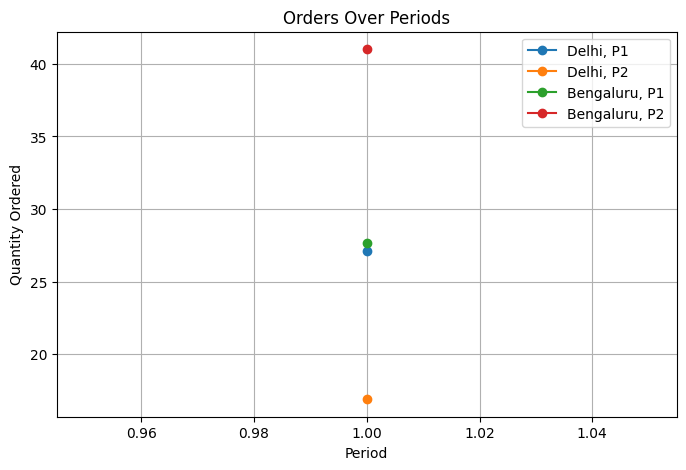

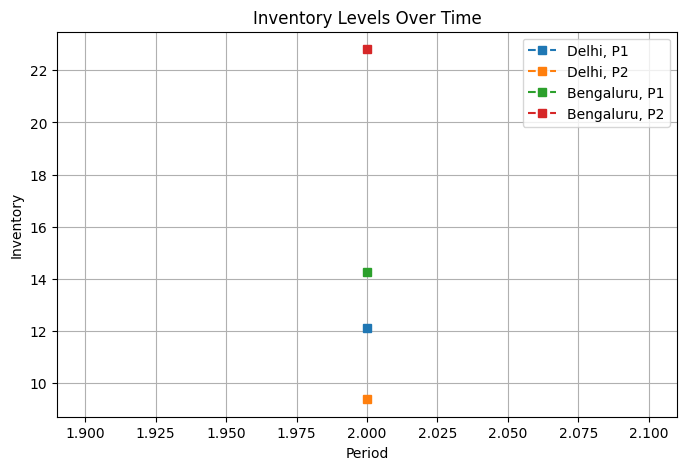

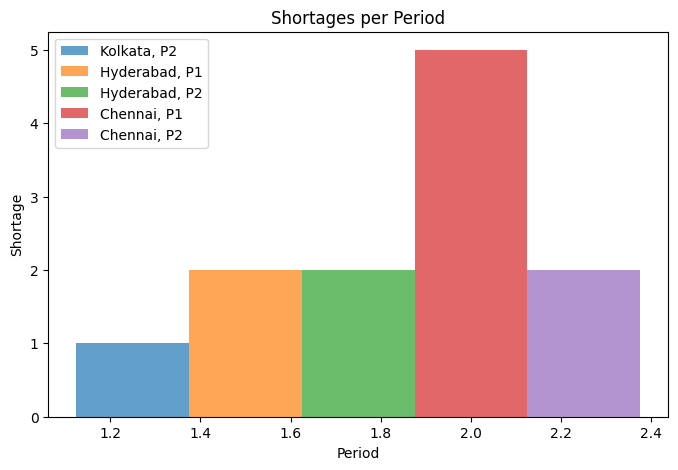

In [8]:
import matplotlib.pyplot as plt

# --- Orders over Periods ---
plt.figure(figsize=(8,5))
for b in Bases:
    for p in Parts:
        x, y = [], []
        for t in Periods:
            val = order_qty[(b, p, t)].value()
            if val is not None and val > 1e-6:  # skip zero orders
                x.append(t)
                y.append(val)
        if x:  # only plot if there’s data
            plt.plot(x, y, marker="o", label=f"{b}, {p}")

plt.title("Orders Over Periods")
plt.xlabel("Period")
plt.ylabel("Quantity Ordered")
plt.legend()
plt.grid(True)
plt.show()

# --- Inventory Levels ---
plt.figure(figsize=(8,5))
for b in Bases:
    for p in Parts:
        x, y = [], []
        for t in Periods:
            val = inventory[(b, p, t)].value()
            if val is not None and val > 1e-6:
                x.append(t)
                y.append(val)
        if x:
            plt.plot(x, y, marker="s", linestyle="--", label=f"{b}, {p}")

plt.title("Inventory Levels Over Time")
plt.xlabel("Period")
plt.ylabel("Inventory")
plt.legend()
plt.grid(True)
plt.show()

# --- Shortages ---
plt.figure(figsize=(8,5))
bar_width = 0.25
for i, s in enumerate(Stations):
    for j, p in enumerate(Parts):
        x, y = [], []
        for t in Periods:
            val = shortage[(s, p, t)].value()
            if val is not None and val > 1e-6:
                x.append(t + (i*len(Parts)+j)*bar_width)  # shift bars to avoid overlap
                y.append(val)
        if x:
            plt.bar(x, y, width=bar_width, alpha=0.7, label=f"{s}, {p}")

plt.title("Shortages per Period")
plt.xlabel("Period")
plt.ylabel("Shortage")
plt.legend()
plt.show()